In [213]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os

In [392]:
# Model Opening
model_path = 'C_SIE'
model_ver = 'C_SIE_POS+FLUX'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result


with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'C_SIE/C_SIE_POS+FLUX', 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 0', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(1, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.60e+02,  20.80, 20.75, 0.11, -4.4, 0.03, 0.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 1, 0)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n',
 '\n',
 '# model_init needs to be done again whenever model parameters are changed\n',
 'glafic.model_init(verb = 0)\n',
 '\n',
 "glafic.readobs_point('/Users/ainsleylewis/Documents/Astronomy/Illus

In [393]:
# Observed Positions 
obs = pd.read_fwf('obs_point/obs_point_(POS+FLUX).dat', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)
obs

plot_obs = obs[['x', 'y', 'm']]
plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
plot_obs['y'] = (plot_obs['y'] - 20) / 0.001
plot_obs

# Critical Curves
crit_curves = pd.read_csv(model_path + '/' + model_ver + '_crit' + '.dat', header=None, names=['1', '2', '3', '4', '5', '6', '7', '8'], delim_whitespace=True)
crit_curves = (crit_curves - 20) / 0.001
crit_curves

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_16114/1426658907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_16114/1426658907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['y'] = (plot_obs['y'] - 20) / 0.001


,1,2,3,4,5,6,7,8
0,791.5,235.0,806.42,715.88,791.0,235.5,806.43,716.34
1,791.5,235.0,806.42,715.88,792.5,235.0,806.42,715.91
2,792.5,235.0,806.42,715.91,793.5,235.0,806.42,715.94
3,793.5,235.0,806.42,715.94,794.5,235.0,806.42,715.97
4,794.5,235.0,806.42,715.97,795.5,235.0,806.42,716.00
...,...,...,...,...,...,...,...,...
4707,838.5,1284.0,813.19,803.59,839.5,1284.0,813.19,803.65
4708,839.5,1284.0,813.19,803.65,840.5,1284.0,813.20,803.70
4709,840.5,1284.0,813.20,803.70,841.5,1284.0,813.20,803.76
4710,841.5,1284.0,813.20,803.76,842.5,1284.0,813.21,803.82


In [394]:
# Extract the line containing 'glafic.startup_setnum('
startup_setnum_line = next(line for line in py if 'glafic.startup_setnum(' in line)

set_point_line = next(line for line in py if 'glafic.set_point(' in line)

# Extract the first number inside the parentheses
extracted_value = int(re.search(r'glafic\.startup_setnum\((\d+)', startup_setnum_line).group(1))

print(extracted_value)

set_point = int(re.search(r'glafic\.set_point\((\d+)', set_point_line).group(1))

print(set_point)

1
1


In [396]:
# Model Values 
# Find the line containing 'lens   sie' in opt_result
model_input = model_path.lower()
if model_input == 'nfw':
    model_input = 'anfw'
if model_input == 'c_sie':
    model_input = 'sie'
if 'SHEAR' in model_path:
    model_input = 'pert'


lens_sie_line = next(line for line in reversed(opt_result) if 'lens   ' + model_input in line)

print(lens_sie_line)

# Extract the values from the line
lens_sie_values = lens_sie_line.split()[2:]
lens_sie_values = [str(value) for value in lens_sie_values]
lens_sie_values

# Find the line containing 'glafic.set_point' in opt_result
set_point_line = next(line for line in reversed(opt_result) if 'point' in line)

print(set_point_line)

# Extract the values from the line
set_point_values = set_point_line.split()[1:]
set_point_values = [str(value) for value in set_point_values]
set_point_values


lens   sie     0.2613  1.618724e+02  2.080980e+01  2.075980e+01  1.158154e-01 -4.429027e+00  2.407818e-02  0.000000e+00 

point  1.0000  2.081269e+01  2.077951e+01 



['1.0000', '2.081269e+01', '2.077951e+01']

In [397]:

name = "'kappa/" + model_path + '/' + model_ver + "'"
name

# Check if the folder exists, and create it if it doesn't
folder_path = 'kappa/' + model_path
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)


In [398]:
model_input_1 = "'" + model_input + "'"

# Read the existing file contents
with open('kappa_glafic.py', 'r') as f:
    py = f.readlines()

# Update values and write back
with open('kappa_glafic.py', 'w') as glafic_file:
    for line in py:
        if 'glafic.set_lens(' in line:
            print('Found glafic.set_lens')
            line = f"glafic.set_lens(1, {model_input_1}, {lens_sie_values[0]}, {lens_sie_values[1]}, {lens_sie_values[2]}, {lens_sie_values[3]}, {lens_sie_values[4]}, {lens_sie_values[5]}, {lens_sie_values[6]}, {lens_sie_values[7]})\n"
        elif 'glafic.init(' in line:
            line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {name}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
        elif 'glafic.set_point(' in line:
            print('Found glafic.set_point')
            # Ensure values are up to date
            if set_point_values is not None and len(set_point_values) == 3:
                line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
            else:
                print("set_point_values is not set correctly.")
        glafic_file.write(line)

Found glafic.set_lens
Found glafic.set_point


In [399]:
%run kappa_glafic.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = kappa/C_SIE/C_SIE_POS+FLUX_lens.fits 



In [400]:
x_cent = float(set_point_values[1])
y_cent = float(set_point_values[2])
print(x_cent, y_cent)

# Predicted Positions 
pred_columns = ['x', 'y', 'mag', 'err']
pred_file = model_path + '/' + model_ver + '_point.dat'
pred = pd.read_fwf(pred_file, sep=' ', header=None, skiprows=1, names=pred_columns)
pred['x_plot'] = (pred['x'] - 20) / 0.001
pred['y_plot'] = (pred['y'] - 20) / 0.001
pred

20.81269 20.77951


,x,y,mag,err,x_plot,y_plot
0,20.7647,20.3042,-7.6369,0.978,764.7,304.2
1,20.8095,20.7576,0.0108,4.270,809.5,757.6
2,21.2760,20.9603,15.2768,0.000,1276.0,960.3
3,20.3933,21.0453,17.3626,0.052,393.3,1045.3
4,20.8199,21.2595,-22.2068,0.157,819.9,1259.5


In [401]:
# FITS File 
image = 'kappa/' + model_path + '/' + model_ver + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: kappa/C_SIE/C_SIE_POS+FLUX_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [402]:
hdu_list[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1560 / length of data axis 1                          
NAXIS2  =                 1560 / length of data axis 2                          
NAXIS3  =                    8 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'LINEAR  '                                                            
CTYPE2  = 'LINEAR  '                                                            
CRPIX1  =                    1                                                  
CRPIX2  =                   

In [403]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa


array([[0.23256603, 0.23273654, 0.23290724, ..., 0.2388148 , 0.23863868,
        0.23846272],
       [0.23269053, 0.23286133, 0.23303229, ..., 0.23895569, 0.23877926,
        0.238603  ],
       [0.23281506, 0.23298614, 0.23315737, ..., 0.23909664, 0.23891991,
        0.23874334],
       ...,
       [0.22356515, 0.2237216 , 0.22387819, ..., 0.23792654, 0.23775837,
        0.23759033],
       [0.22344369, 0.22359988, 0.22375622, ..., 0.23778614, 0.23761828,
        0.23745054],
       [0.22332227, 0.22347823, 0.22363432, ..., 0.23764583, 0.23747826,
        0.23731081]], dtype=float32)

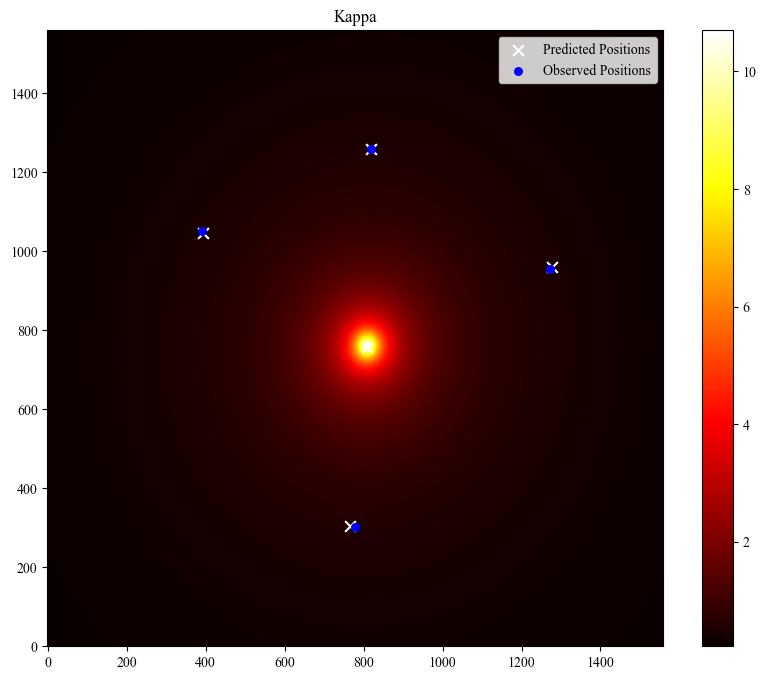

In [404]:
norm = ImageNormalize(stretch=LinearStretch())
plt.figure(figsize=(10, 8))
plt.imshow(kappa, cmap='hot', interpolation='nearest', norm=norm)
plt.gca().invert_yaxis()
plt.colorbar()
plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=60, label='Predicted Positions', marker='x')
plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
plt.title('Kappa')
plt.legend()
plt.show()

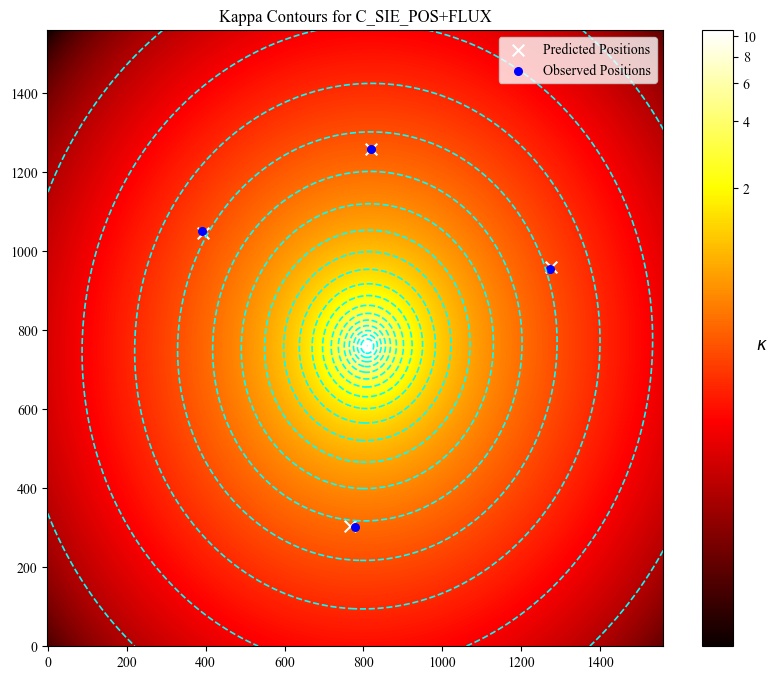

In [405]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(10, 8))
plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
cbar = plt.colorbar(label=r'$\kappa$')
cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa, 
    levels=levels, 
    colors='cyan', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
# plt.scatter(crit_curves['1'], crit_curves['2'], c='yellow', s=5, label='Critical Curves', marker='o')
# plt.scatter(crit_curves['3'], crit_curves['4'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['5'], crit_curves['6'], c='yellow', s=5, marker='o')
# plt.scatter(crit_curves['7'], crit_curves['8'], c='yellow', s=5, marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


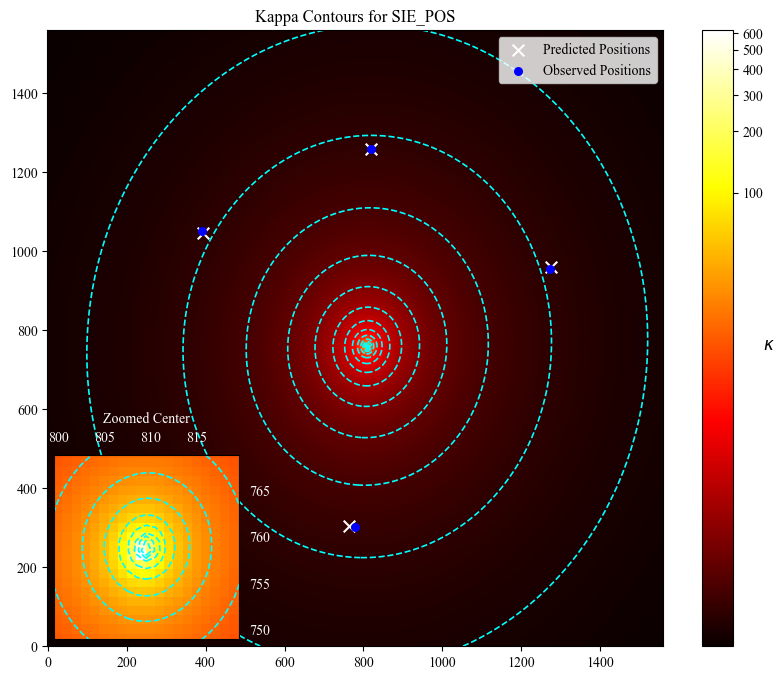

In [284]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(10, 8))
main_ax = plt.gca()
im = main_ax.imshow(kappa, cmap='hot', norm=norm)
main_ax.invert_yaxis()
cbar = plt.colorbar(im, ax=main_ax, label=r'$\kappa$')
cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
contour = main_ax.contour(
    kappa, 
    levels=levels, 
    colors='cyan', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

# Add scatter points
main_ax.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
main_ax.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')

# Add inset plot
inset_ax = inset_axes(main_ax, width="30%", height="30%", loc='lower left')

# Plot the same data in the inset
inset_ax.imshow(kappa, cmap='hot', norm=norm)
inset_ax.invert_yaxis()
inset_ax.contour(
    kappa, 
    levels=levels, 
    colors='cyan', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

x_start = (float(lens_sie_values[2]) - 20) / 0.001
y_start = (float(lens_sie_values[3]) - 20) / 0.001

zoom = 10

inset_ax.set_xlim(x_start - zoom, x_start + zoom)
inset_ax.set_ylim(y_start - zoom, y_start + zoom)

inset_ax.set_title("Zoomed Center", fontsize=10, color='white')
inset_ax.tick_params(axis='x', bottom=False, labelbottom=False, labeltop=True, colors='white')
inset_ax.tick_params(axis='y', left=False, labelleft=False, labelright=True, colors='white')

# Finalize main plot
main_ax.set_title('Kappa Contours for ' + model_ver)
main_ax.legend()
plt.savefig('kappa/Images/kappa_contours_' + model_ver + '.png', dpi=300, bbox_inches='tight')
plt.show()


In [96]:
# Compare 2 Models Side by Side
def compare_models(model_path_1, model_ver_1, model_path_2, model_ver_2):
    
    # Model Opening
    # Model 1
    if 'POS+FLUX' in model_ver_1:
        constraint_1 = 'pos_flux'
    elif 'POS' in model_ver_1:
        constraint_1 = 'pos'

    with open(model_path_1 + '/' + model_ver_1 + '_optresult' + '.dat', 'r') as file:
        opt_result_1 = file.readlines()

    with open(model_path_1 + '/' + constraint_1 + '_point' + '.py', 'r') as file:
        py_1 = file.readlines()

    # Model 2
    if 'POS+FLUX' in model_ver_2:
        constraint_2 = 'pos_flux'
    elif 'POS' in model_ver_2:
        constraint_2 = 'pos'
    
    with open(model_path_2 + '/' + model_ver_2 + '_optresult' + '.dat', 'r') as file:
        opt_result_2 = file.readlines()
    
    with open(model_path_2 + '/' + constraint_2 + '_point' + '.py', 'r') as file:
        py_2 = file.readlines()
    
    # Observed Positions
    obs = pd.read_fwf('obs_point/obs_point_(POS+FLUX).dat', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)

    plot_obs = obs[['x', 'y', 'm']]
    plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
    plot_obs['y'] = (plot_obs['y'] - 20) / 0.001

    # Model Names
    # Model 1
    model_input_1 = model_path_1.lower()
    if model_input_1 == 'nfw':
        model_input_1 = 'anfw'
    if model_input_1 == 'c_sie':
        model_input_1 = 'sie'
    if 'SHEAR' in model_path_1:
        model_input_1 = 'pert'
    
    # Model 1
    model_input_2 = model_path_2.lower()
    if model_input_2 == 'nfw':
        model_input_2 = 'anfw'
    if model_input_2 == 'c_sie':
        model_input_2 = 'sie'
    if 'SHEAR' in model_path_2:
        model_input_2 = 'pert'

    # Lens Line
    # Model 1
    lens_sie_line_1 = next(line for line in reversed(opt_result_1) if 'lens   ' + model_input_1 in line)

    lens_sie_values_1 = lens_sie_line_1.split()[2:]
    lens_sie_values_1 = [str(value) for value in lens_sie_values_1]
    lens_sie_values_1

    set_point_line_1 = next(line for line in reversed(opt_result_1) if 'point' in line)

    set_point_values_1 = set_point_line_1.split()[1:]
    set_point_values_1 = [str(value) for value in set_point_values_1]
    set_point_values_1

    # Model 2 
    lens_sie_line_2 = next(line for line in reversed(opt_result_2) if 'lens   ' + model_input_2 in line)

    lens_sie_values_2 = lens_sie_line_2.split()[2:]
    lens_sie_values_2 = [str(value) for value in lens_sie_values_2]
    lens_sie_values_2

    set_point_line_2 = next(line for line in reversed(opt_result_2) if 'point' in line)

    set_point_values_2 = set_point_line_2.split()[1:]
    set_point_values_2 = [str(value) for value in set_point_values_2]
    set_point_values_2

    
    # Model Location
    # Model 1
    name_1 = "'Kappa/" + model_path_1 + '/' + model_ver_1 + "'"

    # Check if the file exists, and create it if it doesn't
    file_path = 'Kappa/' + model_path_1 + '/' + model_ver_1
    if not os.path.exists(file_path):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        with open(file_path, 'w') as f:
            f.write('')  # Create an empty file
    
    # Model 2
    name_2 = "'Kappa/" + model_path_2 + '/' + model_ver_2 + "'"

    # Check if the file exists, and create it if it doesn't
    file_path = 'Kappa/' + model_path_2 + '/' + model_ver_2
    if not os.path.exists(file_path):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        with open(file_path, 'w') as f:
            f.write('')  # Create an empty file

    # Glafic File
    # Model 1
    model_input_1 = "'" + model_input_1 + "'"

    with open('kappa_glafic.py', 'r') as f:
        py_1 = f.readlines()
    
    with open('kappa_glafic.py', 'w') as glafic_file:
        for line in py_1:
            if 'glafic.set_lens(' in line:
                print('Found glafic.set_lens')
                line = f"glafic.set_lens(1, {model_input_1}, {lens_sie_values_1[0]}, {lens_sie_values_1[1]}, {lens_sie_values_1[2]}, {lens_sie_values_1[3]}, {lens_sie_values_1[4]}, {lens_sie_values_1[5]}, {lens_sie_values_1[6]}, {lens_sie_values_1[7]})\n"
            elif 'glafic.init(' in line:
                line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {name_1}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
            elif 'glafic.set_point(' in line:
                print('Found glafic.set_point')
                if set_point_values_1 is not None and len(set_point_values_1) == 3:
                    line = f"glafic.set_point(1, 1.000, {set_point_values_1[1]}, {set_point_values_1[2]})\n"
                else:
                    print("set_point_values is not set correctly.")
            glafic_file.write(line)
    
    # Run the Glafic File
    # Model 1
    %run kappa_glafic.py
    
    # Model 2
    model_input_2 = "'" + model_input_2 + "'"
    # Read the existing file contents
    with open('kappa_glafic.py', 'r') as f:
        py_2 = f.readlines()
    # Update values and write back

    with open('kappa_glafic.py', 'w') as glafic_file:
        for line in py_2:
            if 'glafic.set_lens(' in line:
                print('Found glafic.set_lens')
                line = f"glafic.set_lens(1, {model_input_2}, {lens_sie_values_2[0]}, {lens_sie_values_2[1]}, {lens_sie_values_2[2]}, {lens_sie_values_2[3]}, {lens_sie_values_2[4]}, {lens_sie_values_2[5]}, {lens_sie_values_2[6]}, {lens_sie_values_2[7]})\n"
            elif 'glafic.init(' in line:
                line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {name_2}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
            elif 'glafic.set_point(' in line:
                print('Found glafic.set_point')
                # Ensure values are up to date
                if set_point_values_2 is not None and len(set_point_values_2) == 3:
                    line = f"glafic.set_point(1, 1.000, {set_point_values_2[1]}, {set_point_values_2[2]})\n"
                else:
                    print("set_point_values is not set correctly.")
            glafic_file.write(line)
    
    # Run the Glafic File
    # Model 2
    %run kappa_glafic.py

    # Predicted Positions
    # Model 1
    pred_columns = ['x', 'y', 'mag', 'err']
    pred_file_1 = model_path_1 + '/' + model_ver_1 + '_point.dat'
    pred_1 = pd.read_fwf(pred_file_1, sep=' ', header=None, skiprows=1, names=pred_columns)
    pred_1['x_plot'] = (pred_1['x'] - 20) / 0.001
    pred_1['y_plot'] = (pred_1['y'] - 20) / 0.001


    # Model 2
    pred_columns = ['x', 'y', 'mag', 'err']
    pred_file_2 = model_path_2 + '/' + model_ver_2 + '_point.dat'
    pred_2 = pd.read_fwf(pred_file_2, sep=' ', header=None, skiprows=1, names=pred_columns)
    pred_2['x_plot'] = (pred_2['x'] - 20) / 0.001
    pred_2['y_plot'] = (pred_2['y'] - 20) / 0.001

    # FITS File
    # Model 1
    image_1 = 'kappa/' + model_path_1 + '/' + model_ver_1 + '_lens' + '.fits'
    hdu_list_1 = fits.open(image_1)
    hdu_list_1.info()
    hdu_list_1[0].header

    # Extract kappa
    kappa_1 = hdu_list_1[0].data[3]
    kappa_1 = np.array(kappa_1)

    # Model 2
    image_2 = 'kappa/' + model_path_2 + '/' + model_ver_2 + '_lens' + '.fits'
    hdu_list_2 = fits.open(image_2)
    hdu_list_2.info()
    hdu_list_2[0].header

    # Extract kappa
    kappa_2 = hdu_list_2[0].data[3]
    kappa_2 = np.array(kappa_2)

    # Plotting
    norm_1 = ImageNormalize(kappa_1, stretch=LogStretch())
    norm_2 = ImageNormalize(kappa_2, stretch=LogStretch())

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    im1 = axs[0].imshow(kappa_1, cmap='hot', norm=norm_1)
    axs[0].invert_yaxis()
    axs[0].set_title('Kappa Contours for ' + model_ver_1)
    axs[0].scatter(pred_1['x_plot'], pred_1['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
    axs[0].scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
    axs[0].legend()
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    axs[0].set_aspect('equal')
    cbar_1 = fig.colorbar(im1, ax=axs[0], label=r'$\kappa$')
    cbar_1.set_label(r'$\kappa$', rotation=0, fontsize=12)
    levels_1 = np.logspace(np.log10(kappa_1.min() + 1e-6), np.log10(kappa_1.max()), 20)
    contour_1 = axs[0].contour(
        kappa_1,
        levels=levels_1,
        colors='cyan',
        linewidths=1.2,
        linestyles='dashed',
        alpha=1,
        extent=[0, kappa_1.shape[1], 0, kappa_1.shape[0]],
    )

    im2 = axs[1].imshow(kappa_2, cmap='hot', norm=norm_2)
    axs[1].invert_yaxis()
    axs[1].set_title('Kappa Contours for ' + model_ver_2)
    axs[1].scatter(pred_2['x_plot'], pred_2['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
    axs[1].scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
    axs[1].legend()
    axs[1].set_xlabel('X Coordinate')
    axs[1].set_ylabel('Y Coordinate')
    axs[1].set_aspect('equal')
    cbar_2 = fig.colorbar(im2, ax=axs[1], label=r'$\kappa$')
    cbar_2.set_label(r'$\kappa$', rotation=0, fontsize=12)
    levels_2 = np.logspace(np.log10(kappa_2.min() + 1e-6), np.log10(kappa_2.max()), 20)
    contour_2 = axs[1].contour(
        kappa_2,
        levels=levels_2,
        colors='cyan',
        linewidths=1.2,
        linestyles='dashed',
        alpha=1,
        extent=[0, kappa_2.shape[1], 0, kappa_2.shape[0]],
    )

    plt.tight_layout()
    plt.show()


/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_16114/1163582712.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_16114/1163582712.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['y'] = (plot_obs['y'] - 20) / 0.001
######## writing lens properties


Found glafic.set_lens
Found glafic.set_point


 zs = 1.000000e+00 
 output file name = Kappa/SIE/SIE_POS_lens.fits 

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Kappa/NFW/NFW_POS_lens.fits 



Found glafic.set_lens
Found glafic.set_point
Filename: kappa/SIE/SIE_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   
Filename: kappa/NFW/NFW_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


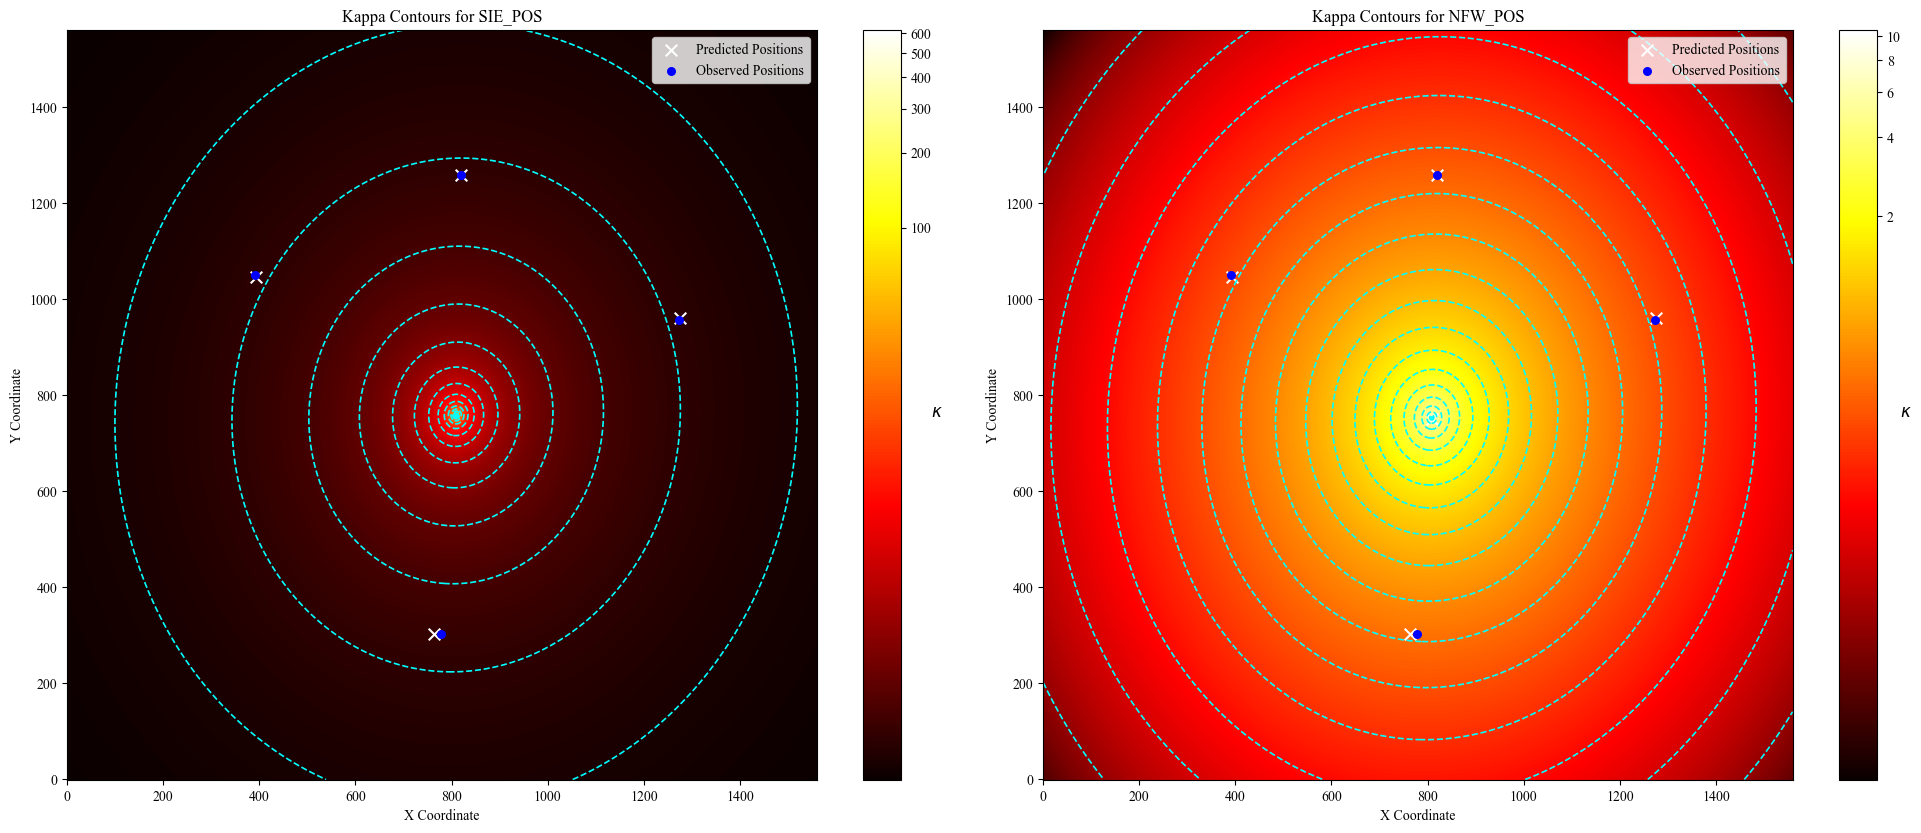

In [97]:
# Compare Models Test
model_path_1 = 'SIE'
model_ver_1 = 'SIE_POS'
model_path_2 = 'NFW'
model_ver_2 = 'NFW_POS'

compare_models(model_path_1=model_path_1, model_ver_1=model_ver_1, model_path_2=model_path_2, model_ver_2=model_ver_2)

Radial Kappa Value: 8.311564445495605


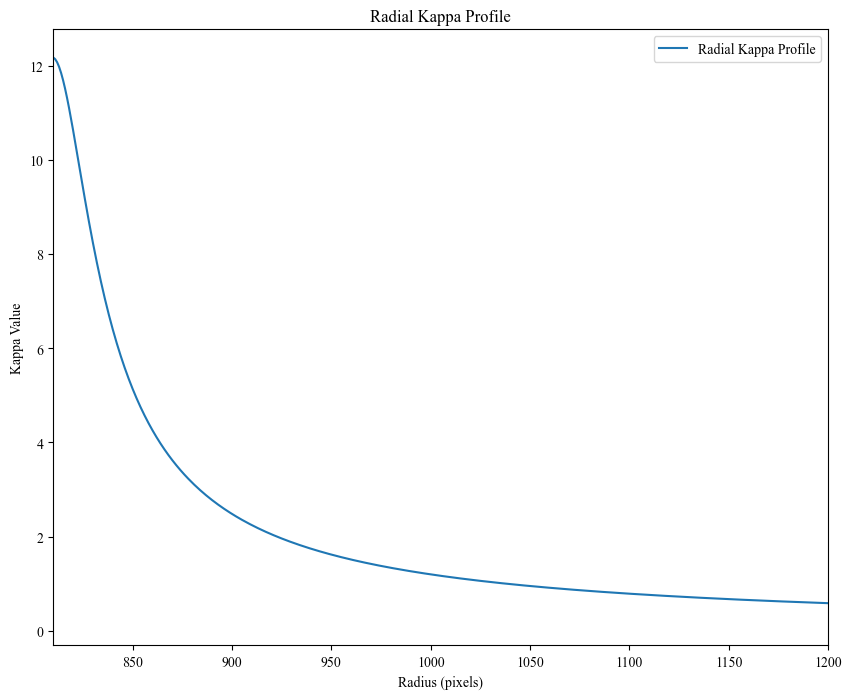

In [65]:
# Radial Kappa Plot
def radial_kappa(kappa, center, radius):
    """
    Calculate the radial kappa profile.
    
    Parameters:
        kappa (2D array): The kappa map.
        center (tuple): The center coordinates (x, y).
        radius (int): The radius for the radial profile.
        
    Returns:
        tuple: The radial distances and corresponding kappa values.
    """
    x_center, y_center = center
    y, x = np.indices(kappa.shape)
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the radius
    mask = (r <= radius)
    
    # Calculate the mean kappa within the radius
    radial_kappa = np.mean(kappa[mask])
    
    return radial_kappa

# Example usage
center = (kappa.shape[1] // 2, kappa.shape[0] // 2)  # Center of the image
radius = 50  # Radius for the radial profile
radial_kappa_value = radial_kappa(kappa, center, radius)
print(f"Radial Kappa Value: {radial_kappa_value}")


# Plot the radial kappa profile
plt.figure(figsize=(10, 8))
plt.plot(kappa[center[1], :], label='Radial Kappa Profile')
plt.xlabel('Radius (pixels)')
plt.ylabel('Kappa Value')
plt.title('Radial Kappa Profile')
plt.xlim(810, 1200)
plt.legend()
plt.show()


Text(0, 0.5, 'Y [arcsec]')

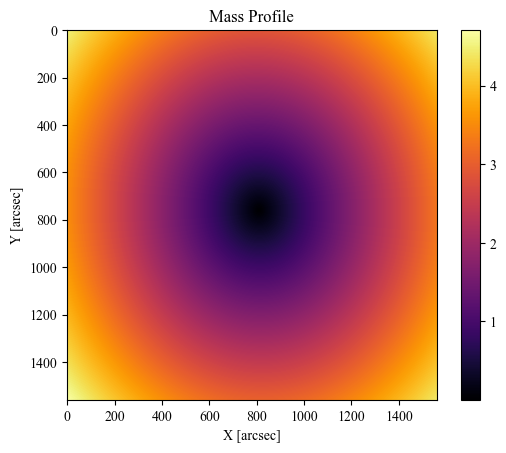

In [164]:
# Mass Profile 
plt.imshow(1/kappa, cmap='inferno')
plt.colorbar()
plt.title('Mass Profile')
plt.xlabel('X [arcsec]')
plt.ylabel('Y [arcsec]')